Import Necessary Libraries 

In [68]:
# System and I/O libraries
import sys
import os
import json
from datetime import date

# Numerical and data manipulation libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# PyTorch libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

# pvlib for working with EPW (EnergyPlus Weather) files
from pvlib.iotools import read_epw

# Geostatistical models - Kriging methods for spatial interpolation
from pykrige.rk import RegressionKriging
from pykrige.ok import OrdinaryKriging

# Serialization library
import pickle

# EPW file handling
from epw import epw


Defining Classes for Neural Network Layers - Geolayer and Custom Model

In [ ]:
# Function to return an LSTM model with specified parameters
def get_lstm_model(embedding_length, hidden_size, output_size):
    class LSTMModel(nn.Module):
        def __init__(self):
            super(LSTMModel, self).__init__()
            # Define LSTM layer and output layer
            self.hidden_size = hidden_size
            self.lstm = nn.LSTM(embedding_length, hidden_size, batch_first=True)
            self.label = nn.Linear(hidden_size, output_size)
        
        def forward(self, input):
            # Dynamically initialize hidden and cell states based on the input batch size
            batch_size = input.size(0)
            h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size))
            c_0 = Variable(torch.zeros(1, batch_size, self.hidden_size))
            
            # Forward pass through LSTM
            output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
            
            # Output from the final hidden state
            return self.label(final_hidden_state[-1])
    
    return LSTMModel()


Training the Model

In [70]:
# Training function
def train_model(model, X_train, y_train, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass
        output = model(X_train)
        loss = criterion(output, y_train)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

All functions created, except for get_lstm and train_model, were used for the error measuring process, so these 2 are the only important ones. The others were created because the people at NUS decided to initialize dataframes by concatenating the file names instead of calling them directly for some reason.

Testing LSTM Model with our CRC EPW Data

In [71]:
CRC = pd.read_csv(r'C:\Users\zeyuj\OneDrive\Desktop\GNI Repo\24Fa-Microclimate-UWG\weather_station_5min\10884521_CleanedWeaterStationData_5min_Intervals.csv')
CRC


,Datetime,Date,Temp,RH,DewPt
0,2017-05-01 15:30:00,05/01/17,23.930,38.433,9.250
1,2017-05-01 15:35:00,05/01/17,24.098,38.154,9.291
2,2017-05-01 15:40:00,05/01/17,23.809,37.597,8.814
3,2017-05-01 15:45:00,05/01/17,23.617,38.598,9.036
4,2017-05-01 15:50:00,05/01/17,23.930,38.334,9.212
...,...,...,...,...,...
16679,2017-06-28 13:25:00,06/28/17,29.439,49.053,17.975
16680,2017-06-28 13:30:00,06/28/17,29.165,48.533,17.556
16681,2017-06-28 13:35:00,06/28/17,29.315,49.134,17.886
16682,2017-06-28 13:40:00,06/28/17,29.140,48.918,17.657


In [72]:
target_col = 'Temp'
feature_cols = ['RH', 'DewPt']

In [73]:
# Extract features and target
features = CRC[feature_cols].values
target = CRC[target_col].values.reshape(-1, 1)

# Normalize features and target
scaler_features = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_target.fit_transform(target)

# Define sequence length
sequence_length = 10


In [74]:
# Function to create sequences for LSTM
def create_sequences(input_data, target_data, seq_length):
    in_seq, out_seq = [], []
    for i in range(len(input_data) - seq_length):
        in_seq.append(input_data[i:i+seq_length])
        out_seq.append(target_data[i + seq_length])
    return np.array(in_seq), np.array(out_seq)

# Create sequences
X, y = create_sequences(features_scaled, target_scaled, sequence_length)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)


In [75]:
# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

In [76]:
print(X_train_tensor.shape[2])

2


In [77]:
# Define model parameters
embedding_length = X_train_tensor.shape[2]  # Number of features
hidden_size = 5
output_size = 1

# Get the LSTM model
model = get_lstm_model(embedding_length=embedding_length, hidden_size=hidden_size, output_size=output_size)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, X_train_tensor, y_train_tensor, criterion, optimizer, epochs=200)

Epoch [10/200], Loss: 0.0881
Epoch [20/200], Loss: 0.0721
Epoch [30/200], Loss: 0.0584
Epoch [40/200], Loss: 0.0478
Epoch [50/200], Loss: 0.0403
Epoch [60/200], Loss: 0.0360
Epoch [70/200], Loss: 0.0341
Epoch [80/200], Loss: 0.0334
Epoch [90/200], Loss: 0.0329
Epoch [100/200], Loss: 0.0324
Epoch [110/200], Loss: 0.0319
Epoch [120/200], Loss: 0.0313
Epoch [130/200], Loss: 0.0307
Epoch [140/200], Loss: 0.0301
Epoch [150/200], Loss: 0.0293
Epoch [160/200], Loss: 0.0285
Epoch [170/200], Loss: 0.0275
Epoch [180/200], Loss: 0.0264
Epoch [190/200], Loss: 0.0251
Epoch [200/200], Loss: 0.0234


Test RMSE: 3.9081


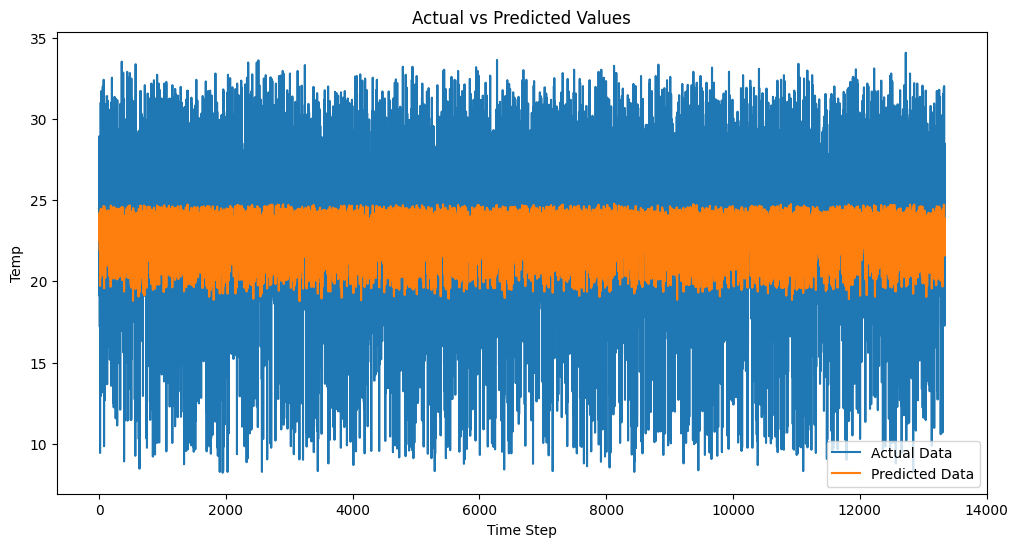

In [78]:
from sklearn.metrics import root_mean_squared_error

# Evaluate the model
model.eval()
with torch.no_grad():
    # Make predictions on test data
    train_predict = model(X_test_tensor)
    predicted = train_predict.data.numpy()
    actual = y_test_tensor.numpy()

    # Inverse transform to get original scale
    predicted_actual = scaler_target.inverse_transform(predicted)
    actual_actual = scaler_target.inverse_transform(actual)

# Calculate RMSE
rmse = root_mean_squared_error(actual_actual, predicted_actual)
print(f'Test RMSE: {rmse:.4f}')

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(actual_actual, label='Actual Data')
plt.plot(predicted_actual, label='Predicted Data')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel(target_col)
plt.title('Actual vs Predicted Values')
plt.show()


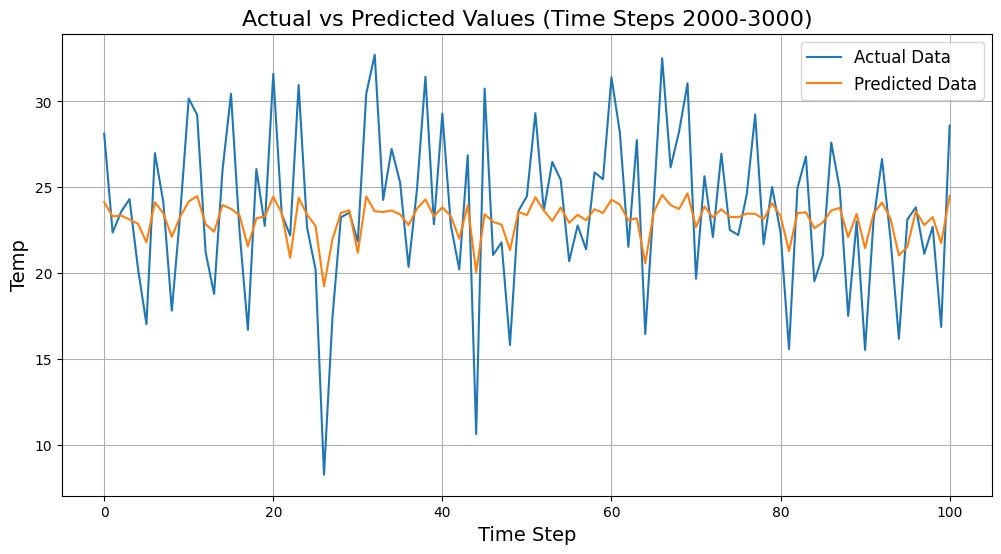

In [79]:
plt.figure(figsize=(12, 6))
plt.plot(actual_actual[2000:2101], label='Actual Data')  # Sliced range
plt.plot(predicted_actual[2000:2101], label='Predicted Data')  # Sliced range
plt.legend(fontsize=12)
plt.xlabel('Time Step', fontsize=14)
plt.ylabel(target_col, fontsize=14)
plt.title('Actual vs Predicted Values (Time Steps 2000-3000)', fontsize=16)
plt.grid()
plt.show()

In [80]:
grid_df = pd.read_csv(r'C:\Users\zeyuj\OneDrive\Desktop\GNI Repo\24Fa-Microclimate-UWG\data\grid_analysis 1.csv')
print(grid_df.columns)
grid_df

Index(['longitude', 'latitude', 'point_id', 'distance_to_building_m',
       'distance_to_park_m', 'distance_to_library_m', 'distance_to_parking_m',
       'distance_to_footway_m', 'distance_to_grass_m',
       'distance_to_fitness_centre_m', 'distance_to_wood_m',
       'distance_to_wetland_m'],
      dtype='object')


,longitude,latitude,point_id,distance_to_building_m,distance_to_park_m,distance_to_library_m,distance_to_parking_m,distance_to_footway_m,distance_to_grass_m,distance_to_fitness_centre_m,distance_to_wood_m,distance_to_wetland_m
0,-84.400799,33.768776,0,422.014674,681.588162,746.040260,409.809199,316.967363,628.809046,897.981949,968.119932,1373.559160
1,-84.402417,33.768810,1,427.542340,814.323966,840.278767,409.848400,416.783930,724.681273,1046.125872,962.324228,1406.080369
2,-84.401878,33.768799,2,420.230287,769.374089,806.992954,404.162537,379.862255,706.150819,996.682875,975.138012,1393.531338
3,-84.401338,33.768788,3,418.144639,725.085827,775.504254,403.912698,346.239543,672.499484,947.298352,970.347964,1382.677540
4,-84.401864,33.769249,4,370.520961,748.180765,769.614078,354.290158,346.393295,663.918141,989.979290,925.526465,1344.972528
...,...,...,...,...,...,...,...,...,...,...,...,...
1331,-84.391192,33.782998,1331,234.651817,840.590319,1021.752264,207.175303,167.623969,458.256298,1423.346507,392.319275,654.090795
1332,-84.391731,33.783010,1332,218.518070,796.965389,1005.802044,202.191174,151.263391,413.790441,1425.432240,349.081644,607.882004
1333,-84.391718,33.783460,1333,266.984650,823.190150,1053.268661,252.180813,200.651201,440.032594,1475.347506,378.063641,629.358664
1334,-84.392257,33.783472,1334,253.821910,781.795222,1039.003754,253.821910,200.109277,399.815430,1479.050146,340.405195,585.424240


In [82]:
spatial_features = ['distance_to_building_m',
       'distance_to_park_m', 'distance_to_library_m', 'distance_to_parking_m',
       'distance_to_footway_m', 'distance_to_grass_m',
       'distance_to_fitness_centre_m', 'distance_to_wood_m',
       'distance_to_wetland_m']
grid_features = grid_df[spatial_features]
grid_coords = grid_df[['longitude', 'latitude']].values

In [ ]:
import os
import pandas as pd

# Path to the folder containing weather station CSV files
folder_path = r"C:\Users\zeyuj\OneDrive\Desktop\GNI Repo\24Fa-Microclimate-UWG\weather_station_5min"

station_coordinates = [()()()()()()()()()()()()()()]

84 Crecine Hall
88 Constructed Wetlands
89 Stamps Field Parking
90 Grass Walkway
91 Allen Parking Lot
92 Clough Parking Loop
93 Tech Square
95 Brittain Drive
96 Tech Tower
97 Glenn Courtyard
07 Constructed Wetland Trees
21 Couch Park Walkway
24 Biology Quad Amphitheater
32 Atlanta Botanical Gardens (Off Campus)

KeyError: 'latitude'

In [ ]:
# Define the bounding box for Georgia Tech campus (adjust coordinates as needed)
campus_bounds = {
    "lat_min": 33.774,  # Southern boundary
    "lat_max": 33.784,  # Northern boundary
    "lon_min": -84.407,  # Western boundary
    "lon_max": -84.396,  # Eastern boundary
}

# Create grid coordinates
num_points = 100  # Number of points for interpolation (increase for finer resolution)
grid_lat = np.linspace(campus_bounds["lat_min"], campus_bounds["lat_max"], num_points)
grid_lon = np.linspace(campus_bounds["lon_min"], campus_bounds["lon_max"], num_points)
grid_coords = np.array([(lat, lon) for lat in grid_lat for lon in grid_lon])


In [ ]:
# Path to the folder containing weather station CSV files
folder_path = r"C:\Users\zeyuj\OneDrive\Desktop\GNI Repo\24Fa-Microclimate-UWG\weather_station_5min"

# List of coordinates for weather stations (replace with actual coordinates)
station_coords = [
    (33.7791, -84.4022),  # Station 1
    (33.7781, -84.4012),  # Station 2
    (33.7801, -84.4032),  # Station 3
    # Add more as needed
]

# Load weather station data
weather_data = []
csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

for i, filename in enumerate(csv_files):
    file_path = os.path.join(folder_path, filename)
    df = pd.read_csv(file_path)
    weather_data.append(df['Temp'].values)  # Replace 'Temp' with the target variable

# Convert weather station data and coordinates to arrays
station_coords = np.array(station_coords)
weather_data = np.array(weather_data)


In [ ]:
# Generate LSTM predictions for each weather station
lstm_predictions = []

for station_data in weather_data:
    # Normalize the data
    station_scaled = scaler_features.transform(station_data.reshape(-1, 1))

    # Convert to PyTorch tensor
    station_tensor = torch.from_numpy(station_scaled).float()

    # Generate predictions
    with torch.no_grad():
        prediction = model(station_tensor.unsqueeze(0))  # Adjust dimensions as needed
        lstm_predictions.append(prediction.numpy().flatten())

# Convert predictions to a NumPy array
lstm_predictions = np.array(lstm_predictions)


In [ ]:
from scipy.interpolate import griddata

# Average LSTM predictions for simplicity
station_avg_predictions = lstm_predictions.mean(axis=1)

# Interpolate predictions onto the Georgia Tech campus grid
grid_predictions = griddata(
    station_coords,  # Weather station coordinates
    station_avg_predictions,  # Predictions for each station
    grid_coords,  # Grid coordinates for the campus
    method='linear',  # Use linear interpolation
)

# Reshape grid predictions to 2D for visualization
grid_predictions_2d = grid_predictions.reshape(len(grid_lat), len(grid_lon))


In [ ]:
from pykrige.ok import OrdinaryKriging

# Apply Ordinary Kriging
ok_model = OrdinaryKriging(
    x=station_coords[:, 1],  # Longitude
    y=station_coords[:, 0],  # Latitude
    z=station_avg_predictions,  # Predictions for each station
    variogram_model="spherical",
    verbose=False,
    enable_plotting=False,
)

# Generate the kriging grid
z, sigma = ok_model.execute("grid", grid_lon, grid_lat)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap for predictions
plt.figure(figsize=(10, 8))
sns.heatmap(
    grid_predictions_2d,  # Grid predictions reshaped to 2D
    cmap="Spectral_r",
    xticklabels=False,
    yticklabels=False,
    cbar_kws={"label": "Temperature (°C)"},  # Adjust label as per target variable
)
plt.title("Spatial Distribution of Predicted Temperature Over Georgia Tech Campus", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
